# HNN(q,p), HNN(q,v), LNN, SYM, SKEW, NODE comparison 
# for mass-spring problem

by Jae Hoon (Daniel) Lee

- HNN(q, p): Hamiltonian NN formulated/trained in the legal (q, p) space
- HNN(q, v): Hamiltonian NN formulated/trained in (q, v) space
- LNN: Langrangian NN
- SYM: Neural Symplectic Form
- SKEW: Skew Matrix Learning
- NODE: Neural ODE

In [1]:
import matplotlib.pyplot as plt

def save_plot_as_image(filename, directory='./figures', format='png', dpi=300):
    import os
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created.")

    full_path = os.path.join(directory, f"{filename}.{format}")
    
    plt.savefig(full_path, format=format, dpi=dpi, bbox_inches='tight')
    
    print(f"Image successfully saved to: {full_path}")

In [2]:
import numpy as np
import pandas as pd
import glob
import os
import re

def parse_filename(filename):
    """
    Obtains model, item, orbit type, tend values by parsing filename.
    """
    # example filename: HNN_ms_Hmodel_hnn_x_tend_5.0.npy
    # example filename: HNN_ms_qp_Hmodel_hnn_x_qp_tend_5.0.npy
    
    # Regular expression pattern definition
    # group 1: Model (e.g., HNN_ms, TRUE_ms_qp, ...)
    # group 2: Item/Energy Type (e.g., Hmodel, Htrue, orbit, ...)
    # group 3: Trajectory Type (e.g., hnn_x, true_x_qp, None, ...)
    # group 4: Tend Value (e.g., 5.0)
    
    pattern = re.compile(r"^(.*?_ms(?:_qp|_qv)?)_((?:Hmodel|Htrue|orbit|qp_orbit|qv_orbit|_Hmodel|_Htrue))(?:_((?:\w+_x(?:_qp|_qv)?|\w+_x)?))?_tend_([0-9.]+)\.npy$")
    
    match = pattern.match(filename)
    
    if match:
        model = match.group(1)
        item = match.group(2)
        trajectory_type = match.group(3) if match.group(3) else 'N/A'
        tend = float(match.group(4))
        
        # Remove underbar from item name (_Hmodel -> Hmodel)
        if item.startswith('_'):
            item = item[1:]

        return {
            'FileName': filename,
            'Model': model,
            'ItemType': item,
            'TrajectoryType': trajectory_type,
            'Tend': tend
        }
    else:
        print(f"Could not parse filename: {filename}")
        return None

def load_and_organize_data(directory='.'):
    """
    Loads all .npy files in the directory and arranges them into Pandas DataFrame.
    """
    file_paths = glob.glob(os.path.join(directory, '*.npy'))
    data_records = []
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        parsed_info = parse_filename(filename)
        
        if parsed_info:
            # Data loading
            try:
                data = np.load(file_path)
                parsed_info['Data'] = data # Stores numpy array into DataFrame cell
                parsed_info['Shape'] = data.shape
                data_records.append(parsed_info)
            except Exception as e:
                print(f"Error loading data from {filename}: {e}")

    # Converts List to Pandas DataFrame
    df = pd.DataFrame(data_records)
    return df

data_directory = '.'

df_comparison = load_and_organize_data(directory=data_directory)

print(df_comparison[['Model', 'ItemType', 'TrajectoryType', 'Tend', 'Shape']])

         Model ItemType TrajectoryType  Tend     Shape
0      NODE_ms    orbit            N/A   5.0  (100, 4)
1      SKEW_ms   Hmodel         skew_x   5.0    (100,)
2      SKEW_ms   Hmodel         true_x   5.0    (100,)
3      SKEW_ms    orbit            N/A   5.0  (100, 4)
4       SYM_ms   Hmodel          sym_x   5.0    (100,)
5       SYM_ms   Hmodel         true_x   5.0    (100,)
6       SYM_ms    orbit            N/A   5.0  (100, 4)
7      TRUE_ms    Htrue          hnn_x   5.0    (100,)
8      TRUE_ms    Htrue          lnn_x   5.0    (100,)
9      TRUE_ms    Htrue         node_x   5.0    (100,)
10     TRUE_ms    Htrue         skew_x   5.0    (100,)
11     TRUE_ms    Htrue          sym_x   5.0    (100,)
12     TRUE_ms    Htrue         true_x   5.0    (100,)
13     TRUE_ms    orbit            N/A   5.0  (100, 4)
14  TRUE_ms_qp    orbit            N/A   5.0  (100, 4)
15  TRUE_ms_qv    orbit            N/A   5.0  (100, 4)
16      HNN_ms   Hmodel          hnn_x   5.0    (100,)
17      HN

In [3]:
"""
1. How to find 'orbit' data only of HNN model
"""
hnn_orbits = df_comparison[
    (df_comparison['Model'].str.contains('HNN_ms')) & 
    (df_comparison['ItemType'] == 'orbit')
]
print("\nHNN Orbits Data:")
print(hnn_orbits[['Model', 'Shape']])


HNN Orbits Data:
        Model     Shape
18     HNN_ms  (100, 4)
23  HNN_ms_qp  (100, 4)
24  HNN_ms_qv  (100, 4)


In [4]:
"""
2. How to ccompare all energy (Hmodel, Htrue) computed with a specific orbit(true_x_qp)
"""
true_x_qp_energies = df_comparison[
    df_comparison['TrajectoryType'] == 'true_x_qp'
]
print("\nEnergies calculated using true_x_qp:")
print(true_x_qp_energies[['Model', 'ItemType', 'TrajectoryType', 'Shape']])


Energies calculated using true_x_qp:
        Model ItemType TrajectoryType   Shape
20  HNN_ms_qp   Hmodel      true_x_qp  (100,)
22  HNN_ms_qp    Htrue      true_x_qp  (100,)


Image successfully saved to: ./figures/ms_orbits_comparison_across_models.png


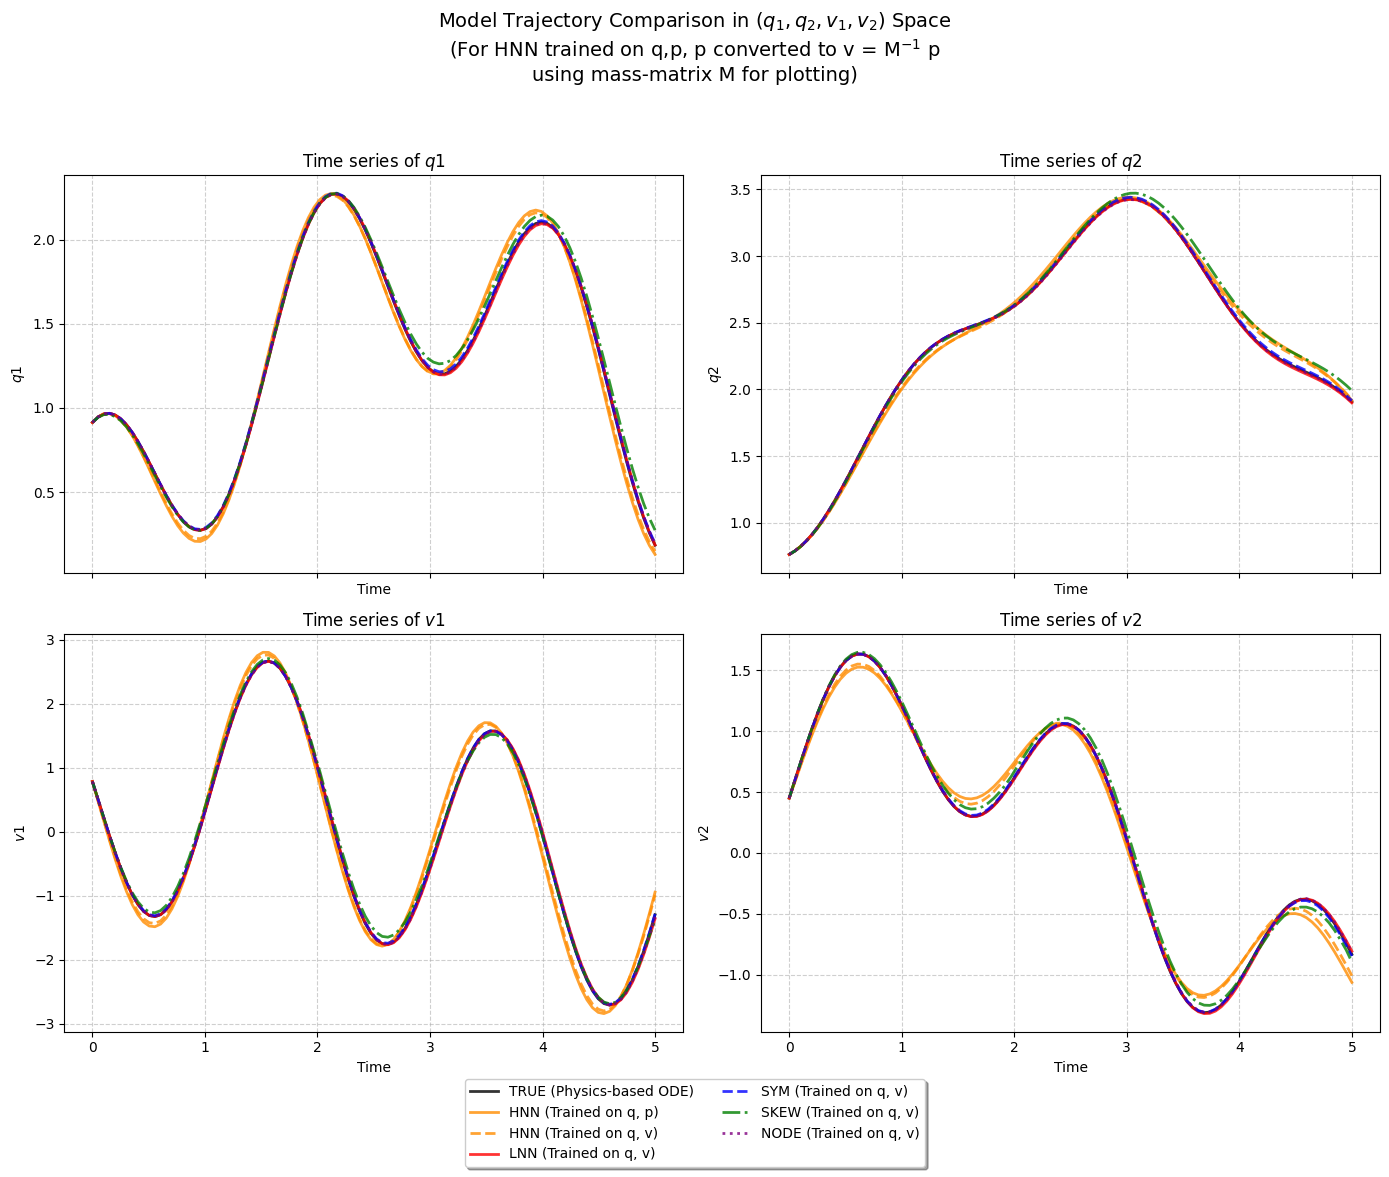

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict

M1 = 1.0 
M2 = 2.0 

def convert_p_to_v(data, model_name, m1, m2):
    if '_qp' in model_name:
        q1, q2, p1, p2 = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
        v1, v2 = p1 / m1, p2 / m2
        converted_data = np.stack([q1, q2, v1, v2], axis=1)
        return converted_data
    else:
        return data

def get_plot_style_and_zorder(model_name):
    styles = {
        'TRUE_ms':      {'color': 'black',      'linestyle': '-',  'zorder': 10},
        'HNN_ms_qv':    {'color': 'darkorange', 'linestyle': '-',  'zorder': 20},
        'HNN_ms':       {'color': 'darkorange', 'linestyle': '--', 'zorder': 30},
        'LNN_ms':       {'color': 'red',        'linestyle': '-',  'zorder': 40},
        'SYM_ms':       {'color': 'blue',       'linestyle': '--', 'zorder': 50},
        'SKEW_ms':      {'color': 'green',      'linestyle': '-.', 'zorder': 60},
        'NODE_ms':      {'color': 'purple',     'linestyle': ':',  'zorder': 70},
    }
    return styles.get(model_name)

def get_legend_label(model_name):
    if model_name == 'TRUE_ms':
        return 'TRUE (Physics-based ODE)'
    elif model_name == 'HNN_ms_qv':
        return 'HNN (Trained on q, p)' 
    else:
        return model_name.replace('_ms', '') + ' (Trained on q, v)'


def plot_ordered_coordinate_comparisons_with_info(df, m1, m2):
    
    models_to_keep_order = [
        'TRUE_ms', 'HNN_ms_qv', 'HNN_ms', 
        'LNN_ms', 'SYM_ms', 'SKEW_ms', 'NODE_ms'
    ]
    
    orbit_data_df = df[
        (df['ItemType'].str.contains('orbit')) &
        (df['Model'].isin(models_to_keep_order))
    ].copy()

    if orbit_data_df.empty:
        print("No filtered orbit data found for plotting.")
        return

    orbit_data_df['Zorder'] = orbit_data_df['Model'].apply(lambda x: get_plot_style_and_zorder(x)['zorder'])
    orbit_data_df['PlotLabel'] = orbit_data_df['Model'].apply(get_legend_label)
    orbit_data_df = orbit_data_df.sort_values(by='Zorder')

    fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True)
    axes = axes.flatten() 

    coords = ['q1', 'q2', 'v1', 'v2']
    T_end = orbit_data_df['Tend'].max()
    
    first_data_shape = orbit_data_df['Data'].iloc[0].shape
    sample_shape_len = first_data_shape[0]
    time_steps = np.linspace(0, T_end, sample_shape_len)

    for index, row in orbit_data_df.iterrows():
        model_name = row['Model']
        raw_data = row['Data']
        
        unified_data = convert_p_to_v(raw_data, model_name, m1, m2)
        style = get_plot_style_and_zorder(model_name)
        plot_label = row['PlotLabel']
        
        for i, coord_name in enumerate(coords):
            axes[i].plot(time_steps, unified_data[:, i], 
                         label=plot_label, 
                         color=style['color'], 
                         linestyle=style['linestyle'],
                         zorder=style['zorder'],
                         alpha=0.8,
                         linewidth=2)
            axes[i].set_title(f'Time series of ${coord_name}$')
            axes[i].set_xlabel('Time')
            axes[i].set_ylabel(f'${coord_name}$')
            axes[i].grid(True, linestyle='--', alpha=0.6)

    handles, labels = [], []
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    
    by_label = OrderedDict(zip(labels, handles))
    unique_handles = list(by_label.values())
    unique_labels = list(by_label.keys())

    fig.legend(unique_handles, unique_labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0.01), fancybox=True, shadow=True)
    
    fig.suptitle(
        f'Model Trajectory Comparison in ($q_1, q_2, v_1, v_2$) Space\n'
        f'(For HNN trained on q,p, p converted to v = M$^{{-1}}$ p\n' 
        f'using mass-matrix M for plotting)', 
        fontsize=14, y=0.98
    )

    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    save_plot_as_image("ms_orbits_comparison_across_models")
    plt.show()

plot_ordered_coordinate_comparisons_with_info(df_comparison, M1, M2)

In [6]:
import numpy as np
import pandas as pd
import glob
import os
import re

# parse_filename fucntion (the same as before)
def parse_filename(filename):
    pattern = re.compile(r"^(.*?_ms(?:_qp|_qv)?)_((?:Hmodel|Htrue|orbit|qp_orbit|qv_orbit|_Hmodel|_Htrue))(?:_((?:\w+_x(?:_qp|_qv)?|\w+_x)?))?_tend_([0-9.]+)\.npy$")
    match = pattern.match(filename)
    if match:
        model = match.group(1)
        item = match.group(2)
        trajectory_type = match.group(3) if match.group(3) else 'N/A'
        if item.startswith('_'):
            item = item[1:]
        return {
            'FileName': filename,
            'Model': model,
            'ItemType': item,
            'TrajectoryType': trajectory_type,
            'Tend': float(match.group(4))
        }
    else:
        # check
        print(f"Could not parse filename in check: {filename}")
        return None

def load_and_organize_data_with_check(directory='.'):
    file_paths = glob.glob(os.path.join(directory, '*.npy'))
    data_records = []
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        parsed_info = parse_filename(filename)
        
        if parsed_info:
            try:
                data = np.load(file_path)
                parsed_info['Data'] = data 
                parsed_info['Shape'] = data.shape
                data_records.append(parsed_info)
            except Exception as e:
                print(f"Error loading data from {filename}: {e}")

    df = pd.DataFrame(data_records)
    return df

data_directory = '.'
df_comparison = load_and_organize_data_with_check(directory=data_directory)

print("\n--- DataFrame Contents Check for Hmodel on TRUE Traj ---")
check_df = df_comparison[
    (df_comparison['ItemType'] == 'Hmodel') & 
    ( (df_comparison['TrajectoryType'] == 'true_x') | (df_comparison['TrajectoryType'] == 'true_x_qp') )
]
print(check_df[['FileName', 'Model', 'TrajectoryType']])
print(f"Total relevant Hmodel on TRUE Traj records found: {len(check_df)}")
# --------------------


--- DataFrame Contents Check for Hmodel on TRUE Traj ---
                                   FileName      Model TrajectoryType
2        SKEW_ms_Hmodel_true_x_tend_5.0.npy    SKEW_ms         true_x
5         SYM_ms_Hmodel_true_x_tend_5.0.npy     SYM_ms         true_x
17        HNN_ms_Hmodel_true_x_tend_5.0.npy     HNN_ms         true_x
20  HNN_ms_qp_Hmodel_true_x_qp_tend_5.0.npy  HNN_ms_qp      true_x_qp
26        LNN_ms_Hmodel_true_x_tend_5.0.npy     LNN_ms         true_x
Total relevant Hmodel on TRUE Traj records found: 5


Image successfully saved to: ./figures/ms_true_energy_comparison_across_models.png
Image successfully saved to: ./figures/ms_learned_energy_comparison_across_models.png


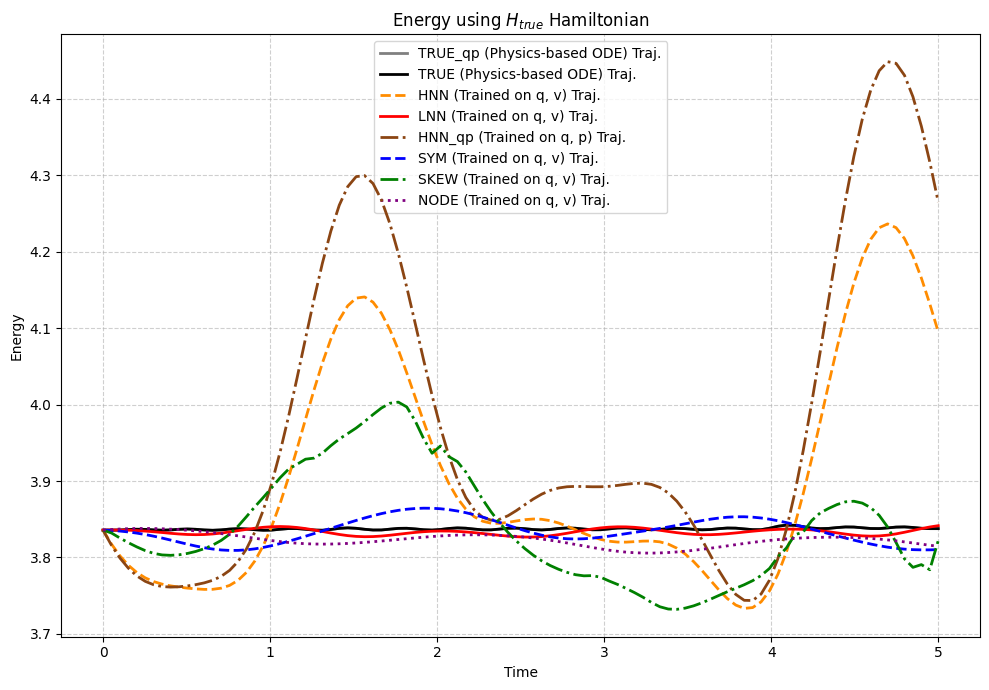

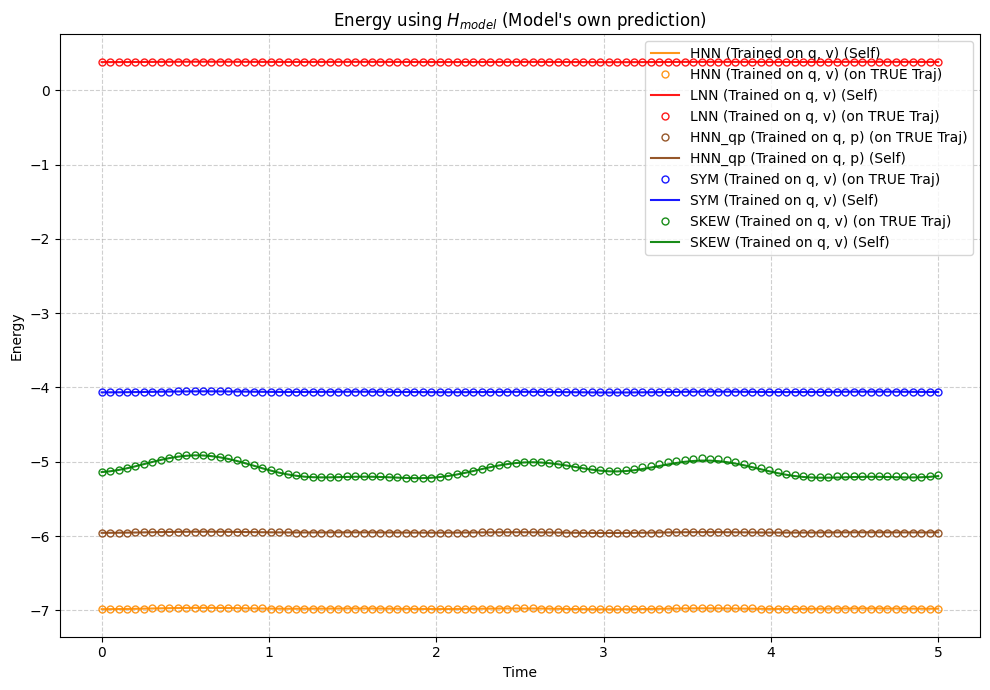

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict

M1 = 1.0 
M2 = 2.0 

def get_plot_style_and_zorder(model_name):
    styles = {
        'TRUE_ms':      {'color': 'black',      'linestyle': '-',  'zorder': 10},
        'TRUE_ms_qp':   {'color': 'gray',       'linestyle': '-',  'zorder': 10},
        'HNN_ms_qv':    {'color': 'darkorange', 'linestyle': '-',  'zorder': 20}, # HNN (q,v)
        'HNN_ms':       {'color': 'darkorange', 'linestyle': '--', 'zorder': 30}, # HNN (q,v)
        'LNN_ms':       {'color': 'red',        'linestyle': '-',  'zorder': 40},
        'SYM_ms':       {'color': 'blue',       'linestyle': '--', 'zorder': 50},
        'SKEW_ms':      {'color': 'green',      'linestyle': '-.', 'zorder': 60},
        'NODE_ms':      {'color': 'purple',     'linestyle': ':',  'zorder': 70},
        'HNN_ms_qp':    {'color': 'saddlebrown', 'linestyle': '-.', 'zorder': 45}, # HNN_qp (q,p)
    }
    return styles.get(model_name, {'color': 'cyan', 'linestyle': '-', 'zorder': 5})

def get_legend_label(model_name):
    if model_name == 'TRUE_ms':
        return 'TRUE (Physics-based ODE)'
    elif model_name == 'TRUE_ms_qp':
        return 'TRUE_qp (Physics-based ODE)'
    elif model_name == 'HNN_ms_qv':
        return 'HNN (Trained on q, p)' 
    elif model_name == 'HNN_ms_qp':
         return 'HNN_qp (Trained on q, p)'
    else:
        return model_name.replace('_ms', '') + ' (Trained on q, v)'

def map_traj_type_to_model_name(traj_type):
    mapping = {
        'true_x': 'TRUE_ms', 'true_x_qp': 'TRUE_ms_qp', 'true_x_qv': 'TRUE_ms',
        'hnn_x': 'HNN_ms', 'hnn_x_qp': 'HNN_ms_qp', 'hnn_x_qv': 'HNN_ms_qv', 
        'lnn_x': 'LNN_ms',
        'sym_x': 'SYM_ms',
        'skew_x': 'SKEW_ms',
        'node_x': 'NODE_ms',
    }
    return mapping.get(traj_type, None)

def plot_energy_comparisons_separated_final_v4(df):
    
    T_end = df['Tend'].max()
    first_data_shape = df['Data'].iloc[0].shape 
    sample_shape_len = first_data_shape[0] 
    time_steps = np.linspace(0, T_end, sample_shape_len)

    # --- Plot 1: Htrue (Ground Truth Energy) ---
    fig1, ax1 = plt.subplots(figsize=(10, 7))
    htrue_df = df[df['ItemType'] == 'Htrue'].copy()
    htrue_df['ModelName'] = htrue_df['TrajectoryType'].apply(map_traj_type_to_model_name)
    htrue_df = htrue_df.dropna(subset=['ModelName']) 
    htrue_df['Zorder'] = htrue_df['ModelName'].apply(lambda x: get_plot_style_and_zorder(x)['zorder'])
    htrue_df = htrue_df.sort_values(by='Zorder')

    for index, row in htrue_df.iterrows():
        energy_data = row['Data'].flatten() 
        style = get_plot_style_and_zorder(row['ModelName'])
        label = f"{get_legend_label(row['ModelName'])} Traj." 
        ax1.plot(time_steps, energy_data, label=label, color=style['color'], 
                     linestyle=style['linestyle'], zorder=style['zorder'], linewidth=2)
    
    ax1.set_title('Energy using $H_{true}$ Hamiltonian')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Energy')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend(loc='best', ncol=1)
    plt.tight_layout()

    save_plot_as_image("ms_true_energy_comparison_across_models")

    # --- Plot 2: Hmodel (Model's Own Energy or Specific Comparison) ---
    fig2, ax2 = plt.subplots(figsize=(10, 7))
    hmodel_df = df[df['ItemType'] == 'Hmodel'].copy()
    hmodel_filtered_self_df = df[
        (df['ItemType'] == 'Hmodel') &
        df.apply(lambda row: map_traj_type_to_model_name(row['TrajectoryType']) == row['Model'], axis=1)
    ].copy()
    hmodel_on_true_traj_df = df[
        (df['ItemType'] == 'Hmodel') &
        ((df['TrajectoryType'] == 'true_x') | (df['TrajectoryType'] == 'true_x_qp'))
    ].copy()
    
    hmodel_to_plot = pd.concat([hmodel_filtered_self_df, hmodel_on_true_traj_df])
    
    subset_cols = [col for col in hmodel_to_plot.columns if col not in ['Data', 'Shape']]
    hmodel_to_plot = hmodel_to_plot.drop_duplicates(subset=subset_cols)

    hmodel_to_plot['Zorder'] = hmodel_to_plot['Model'].apply(lambda x: get_plot_style_and_zorder(x)['zorder'])
    hmodel_to_plot = hmodel_to_plot.sort_values(by='Zorder')

    for index, row in hmodel_to_plot.iterrows():
        energy_data = row['Data'].flatten()
        style = get_plot_style_and_zorder(row['Model'])
        
        is_self_consistent = map_traj_type_to_model_name(row['TrajectoryType']) == row['Model']
        
        if is_self_consistent:
             label = f"{get_legend_label(row['Model'])} (Self)"
             current_linestyle = '-' 
             current_marker = None
             current_linewidth = 1.5
             current_mfc = style['color'] 
        else:
             label = f"{get_legend_label(row['Model'])} (on TRUE Traj)"
             current_linestyle = 'None'
             current_marker = 'o'
             current_linewidth = 0      
             style['zorder'] = style['zorder'] + 0.5 
             current_mfc = 'none' # open marker

        ax2.plot(time_steps, energy_data, label=label, 
                 color=style['color'],           
                 linestyle=current_linestyle,
                 marker=current_marker, 
                 markersize=5,                   
                 markerfacecolor=current_mfc,    
                 zorder=style['zorder'], 
                 alpha=0.9, 
                 linewidth=current_linewidth)
    
    ax2.set_title('Energy using $H_{model}$ (Model\'s own prediction)')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Energy')
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend(loc='best', ncol=1)
    plt.tight_layout()

    save_plot_as_image("ms_learned_energy_comparison_across_models")

    plt.show()

plot_energy_comparisons_separated_final_v4(df_comparison)